In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
import re
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
from IPython.display import clear_output

In [ ]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058592.265680.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.137771.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.382709.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382712.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382713.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.84280.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.104236.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.186729.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058601.173596.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058601.382726.jpg  
  inflating: ut-zap50k-images/Sho

In [ ]:
# https://drive.google.com/file/d/1yU9MA5pbGx8ScsnQ0PoqQp4KgeEpvfqL/view?usp=sharing
meta = pd.read_csv("meta-data.csv")
print("Labels file found")
meta.head()

Labels file found


,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle
0,100627-72,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
1,100627-255,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
3,100657-216,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
4,101026-3,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Men,Leather;Rubber,Square Toe;Closed Toe


In [ ]:
import os
from collections import defaultdict
import random

folder = "ut-zap50k-images"
classes = {}
numofpics = defaultdict(int)
img_paths = []
count = 0
for cat in os.listdir(folder):
  folder1 = folder + "/" + cat
  for subcat in os.listdir(folder1):
    folder2 = folder1 + "/" + subcat
    classes[cat + ", " + subcat] = count
    classes[count] = cat + ", " + subcat
    count += 1
    for brand in os.listdir(folder2):
      folder3 = folder2 + "/" + brand
      for pic in os.listdir(folder3):
        if random.randint(1,10) > 6:
          continue
        numofpics[cat + ", " + subcat] += 1
        img_paths.append(folder3 + "/" + pic)

print(len(img_paths))
numofpics

30101


defaultdict(int,
            {'Boots, Ankle': 3562,
             'Boots, Knee High': 1340,
             'Boots, Mid-Calf': 2889,
             'Boots, Over the Knee': 25,
             'Boots, Prewalker Boots': 2,
             'Sandals, Athletic': 5,
             'Sandals, Flat': 3366,
             'Sandals, Heel': 79,
             'Shoes, Boat Shoes': 376,
             'Shoes, Clogs and Mules': 826,
             'Shoes, Crib Shoes': 10,
             'Shoes, Firstwalker': 209,
             'Shoes, Flats': 2406,
             'Shoes, Heels': 3407,
             'Shoes, Loafers': 1676,
             'Shoes, Oxfords': 1275,
             'Shoes, Prewalker': 157,
             'Shoes, Sneakers and Athletic Shoes': 7708,
             'Slippers, Boot': 7,
             'Slippers, Slipper Flats': 768,
             'Slippers, Slipper Heels': 8})

In [ ]:
temp = numofpics.copy()
temp["Other"] = 0
for key, val in numofpics.items():
  if val < 1000:
    temp["Other"] += val
    temp.pop(key)
    classes.pop(key)
    classes[key] = 22

classes[22] = "Other"
classes["Other"] = 22

numofpics = temp.copy()

In [ ]:
num_classes = len(numofpics)

In [ ]:
id2label = {x:i for i, x in enumerate(classes[x] for x in numofpics.keys())}
label2id = {i:x for i, x in id2label.items()}

In [ ]:
def get_label(img_path, meta):
  crop = re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]
  code = crop.replace('.','-')
  label = "Other"
  try:
    label = ", ".join(np.array(meta.loc[meta['CID'] == code])[0][1:3])
  except:
    print("Error in label at",img_path, code, np.array(meta.loc[meta['CID'] == code]))
  return label

In [ ]:
class ShoesDataset(Dataset):
  def __init__(self, csv_path, img_paths, transform):
        """
        Args:
            csv_path (string): Csv file with labels.
            img_paths (list): List of all images' path names.
            transform (callable): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv("meta-data.csv")
        self.transform = transform
        tmpi = []
        self.labels = []
        for i in tqdm.tqdm(img_paths, "Loading"):
          img = io.imread(i)
          if img.shape != (102, 136, 3):
            continue
          self.labels.append(id2label[classes[get_label(i, self.csv)]])
          tmpi.append(transform(img))
        
        self.imgs = torch.stack(tmpi)
        

  def __len__(self):
      return len(self.imgs)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      return [self.imgs[idx], self.labels[idx]]

Loading: 100%|██████████| 30101/30101 [02:07<00:00, 235.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


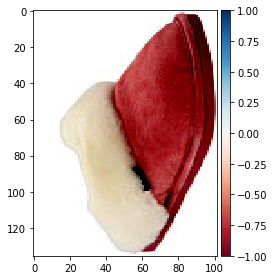

In [ ]:
transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = ShoesDataset("meta-data.csv", img_paths, transform)
io.imshow(ds[0][0].cpu().numpy().T)

In [ ]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=512
        )
        self.encoder_output_layer = nn.Linear(
            in_features=512, out_features=512
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=512, out_features=512
        )
        self.decoder_output_layer = nn.Linear(
            in_features=512, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [ ]:
model = AE(input_shape=102*136).to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=4
)

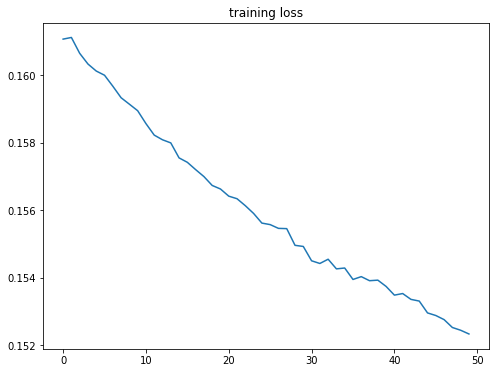

epoch : 50/50, loss = 0.152337


In [ ]:
epochs = 50
loss = []

for epoch in range(epochs):
    batchloss = 0
    for batch_features, _ in trainloader:
        batch_features = batch_features.view(-1, 102*136).to("cuda")
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = count_loss(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

In [ ]:
with torch.no_grad():
  batchloss = 0
  for testx, testy in testloader:
    testx = testx.view(-1, 102*136).to("cuda")

    outputs = model(testx)
    batchloss += count_loss(outputs, testx)
    
  testloss = batchloss / len(testloader)
print(f"Test loss: {testloss}")

Test loss: 0.15530070662498474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


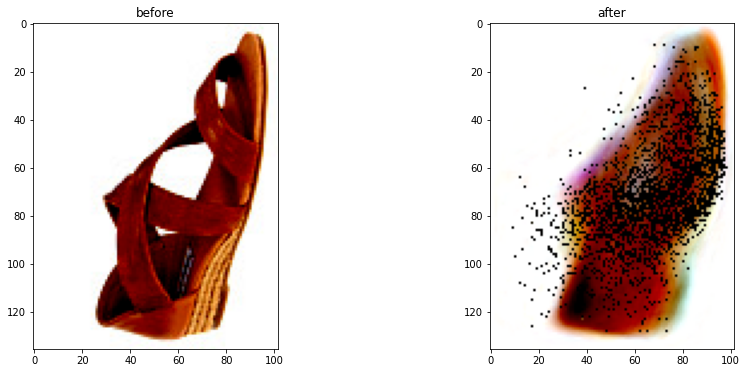

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


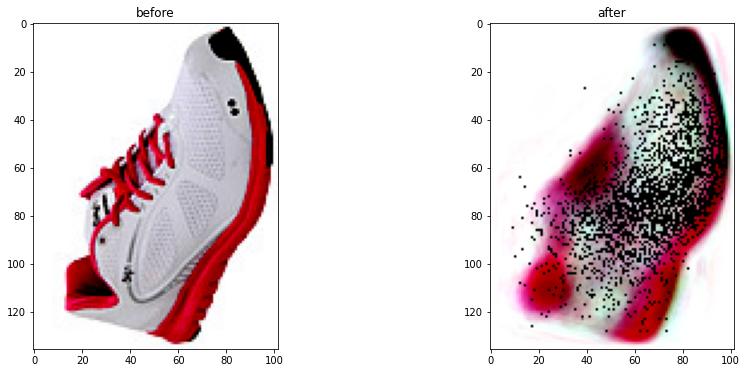

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


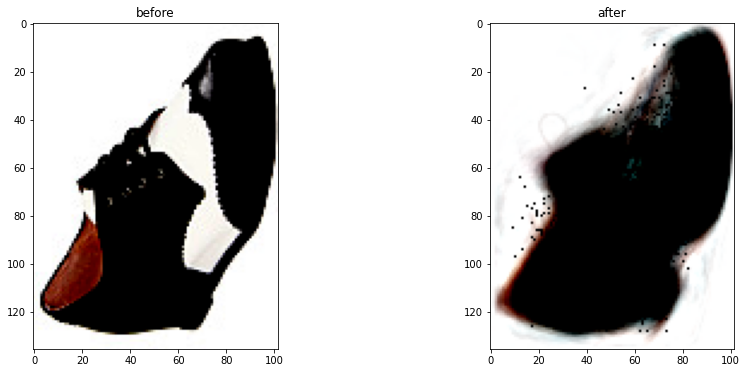

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


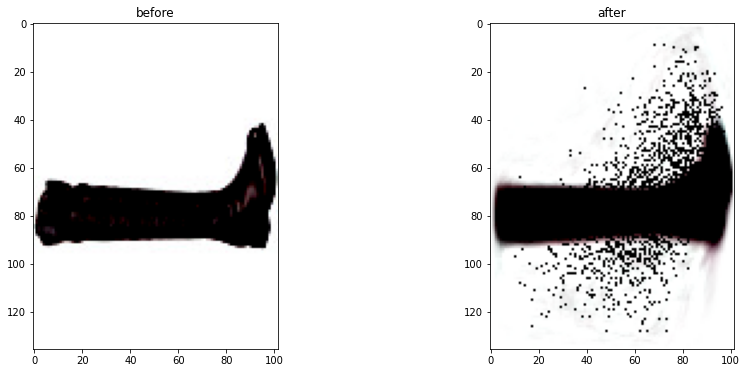

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


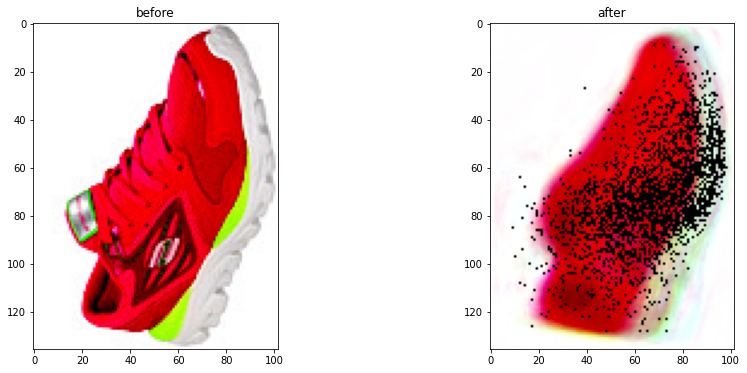

In [ ]:
with torch.no_grad():
  for i in range(5):
    testx, label = random.choice(ds)
    testx = testx.view(-1, 102*136).to("cuda")

    predicted = model(testx)
    predicted = predicted.view(3, 102, 136)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].imshow(testx.view(3, 102, 136).to("cpu").numpy().T)
    axs[0].set_title('before')
    axs[1].imshow(predicted.to("cpu").numpy().T)
    axs[1].set_title('after')
    plt.show()

In [ ]:
torch.save(AE, "ae.pt")

In [ ]:
# convolutional encoders
# read articles
# alpha x + (1 - alpha) y
# поиграться с латентным пространством
# подольше поучить